# Generating DRMs for GBM detectors

The main purpose for ```gbm_drm_gen``` is a fast and easy way to generate detector response matrices for the Fermi-GBM detectors in a pythonic way.




When we want to generate DRMS for GBM detectors, we simply need to obtain the proper data 

In [1]:
import matplotlib.pyplot as plt


import numpy as np

%matplotlib inline

from jupyterthemes import jtplot

jtplot.style(context="talk", grid=False)

from gbm_drm_gen import DRMGenTTE
from gbm_drm_gen.utils.package_data import get_path_of_data_file





## quick start

To create a DRM generator for TTE data, we need the TTE, CSPEC, and the TRIGDAT data files.
* The CSPEC data contains the output side of the DRM's energy bounds. 
* The TRIGDAT data contains the spacecraft orientation data.

In [2]:
trigdat_file = get_path_of_data_file('example_data/glg_trigdat_all_bn110721200_v01.fit')
cspec_file = get_path_of_data_file('example_data/glg_cspec_n6_bn110721200_v00.pha')


# create the generator
gbm_n6_generator = DRMGenTTE(det_name= "n6",
                             time=0, # time relative to T0 or trigger time.
                             trigdat = trigdat_file,
                             mat_type = 2, # direct response + atmospheric scattering
                             cspecfile = cspec_file)

We can set the location of the source directly. The first run can be a bit slow as ```numba``` is used in the background to be very fast. 

In [3]:
gbm_n6_generator.set_location(ra=329,dec = -38.2)

We can now checkout the matrix object created in the background:

In [4]:
gbm_n6_generator.matrix

array([[1.21529588e-02, 2.66685346e-02, 3.35702294e-02, ...,
        1.71696052e-02, 1.79967322e-02, 0.00000000e+00],
       [2.40656348e-03, 9.02243768e-03, 2.44969585e-02, ...,
        1.76004235e-02, 1.84410737e-02, 0.00000000e+00],
       [0.00000000e+00, 6.64336828e-04, 4.79652366e-03, ...,
        1.75084305e-02, 1.83343065e-02, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.18137462e-01, 1.18589681e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.19105016e-01, 1.19567934e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.49905465e+00, 2.50882594e+00, 0.00000000e+00]])

Or we can input RA and DEC to create a 3ML style OGIP response directly:

In [5]:
response = gbm_n6_generator.to_3ML_response(ra=329,dec = -38.2)

/opt/hostedtoolcache/Python/3.8.11/x64/lib/python3.8/site-packages/responsum-0.1.4-py3.8.egg/responsum/response.py:270: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("ocean").copy()


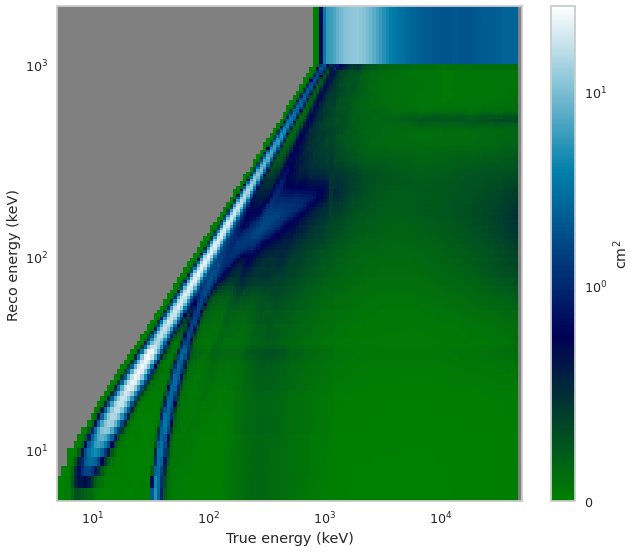

In [6]:
fig = response.plot_matrix()

To see how the effective area varies with location, we can loop through various angles.

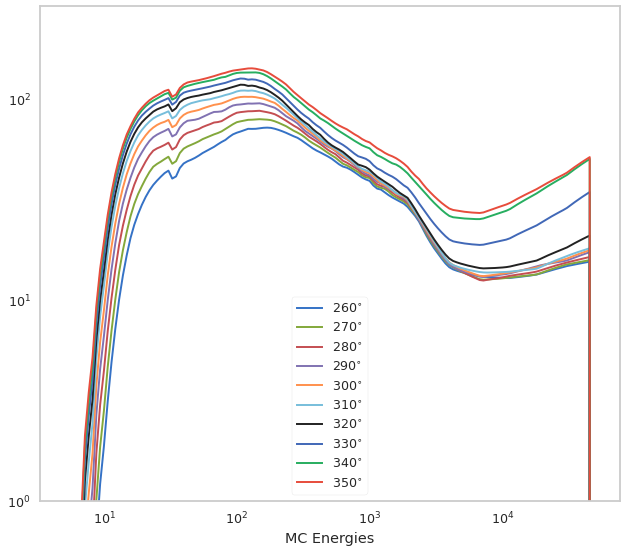

In [7]:
fig, ax = plt.subplots()

bounds = np.vstack((gbm_n6_generator.monte_carlo_energies[:-1],gbm_n6_generator.monte_carlo_energies[1:])).T
de = np.diff(bounds)
ene = np.mean(bounds,axis=1)

for ra in np.linspace(260, 350, 10):
    
    gbm_n6_generator.set_location(ra=ra,dec = -38.2)

    ax.loglog(ene,gbm_n6_generator.matrix.sum(axis=0),label=r'%d$^{\circ}$'%ra)

ax.set_ylim(1)
ax.legend()
ax.set_xlabel(r'Effective Area (cm$^2$)');
ax.set_xlabel('MC Energies');

## Into the details

Ok, now let's go through the various specifics of the DRM generator constructor.


First, the generator needs to know:

* The current location and oreintation of GBM for the data of interest.

* The channel to PHA reconstructed energy from the CSPEC files. 


For the first, one can get the current spacecraft from the either the triggers trigdat file, or for non-trggered data, one can obtain the position history file. These are available at the [NASA database](https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/). If using a position history file. You need to specify ```T0=<Fermi MET>``` in the constructor so that the time coordinate will be relative to this MET.

Internally, the class uses [gbmgeometry](https://gbmgeometry.readthedocs.io/en/latest/) to convert RA,Dec to the approriate spacecraft coordinates. However, one can also create DRMs in spacecraft coordinates directly. 


## custom energy binning

Maybe you are a curious person and want to investigate a response with finer input energies to model line features in solar flares? 

It is possible to add a custom array of input energies. To do this we need to import the ```NaITTEEdges``` and ```BgoTTEEdges``` classes.


In [8]:
from gbm_drm_gen import  NaiTTEEdges, BgoTTEEdges

These objects allow you to specify input (monte carlo) energies either from an array or in log spaced binning.

<div class="alert alert-info">

**Note:** The number of energies must be off and include the low and high end points which are specific to the NaI [5.0, 50000.0] and BGO [100., 200000.0] detectors.

</div>

### Log-spaced energies

First we will try with **VERY** fine log spaced binning above the typical 140 input energies


/opt/hostedtoolcache/Python/3.8.11/x64/lib/python3.8/site-packages/responsum-0.1.4-py3.8.egg/responsum/response.py:270: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("ocean").copy()


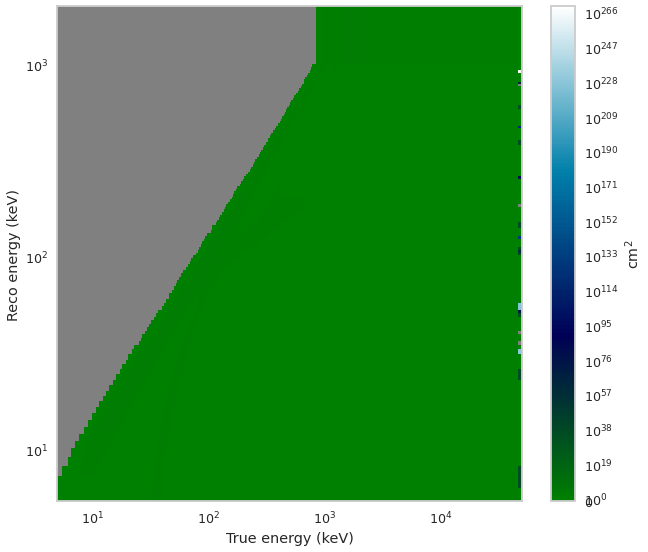

In [9]:
custom_edges = NaiTTEEdges.from_log_bins(n_bins=531)


gbm_n6_generator = DRMGenTTE(det_name= "n6",
                             trigdat = trigdat_file,
                             mat_type = 2, # direct response + atmospheric scattering
                             cspecfile = cspec_file,
                             # pass the custom edges
                             custom_input_edges=custom_edges
                            
                            )


response = gbm_n6_generator.to_3ML_response(ra=329,dec = -38.2)

fig = response.plot_matrix()

And now with a much coarser input binning:

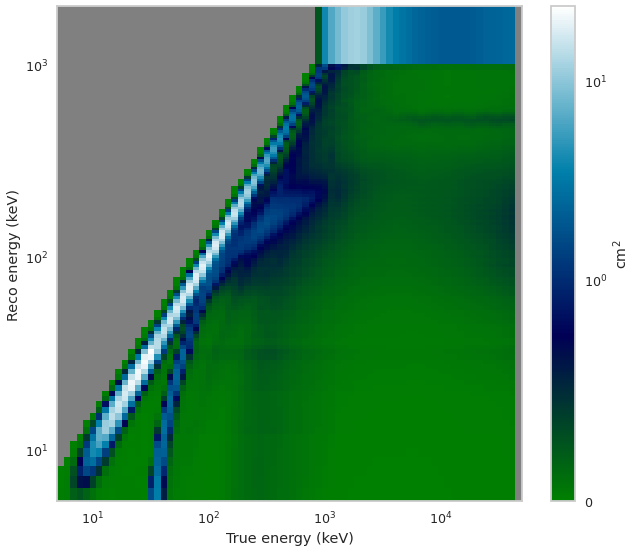

In [10]:
custom_edges = NaiTTEEdges.from_log_bins(n_bins=73)


gbm_n6_generator = DRMGenTTE(det_name= "n6",
                             trigdat = trigdat_file,
                             mat_type = 2, # direct response + atmospheric scattering
                             cspecfile = cspec_file,
                             # pass the custom edges
                             custom_input_edges=custom_edges
                            
                            )


response = gbm_n6_generator.to_3ML_response(ra=329,dec = -38.2)

fig = response.plot_matrix()

It is easier to see the difference with simple matrix plotting:

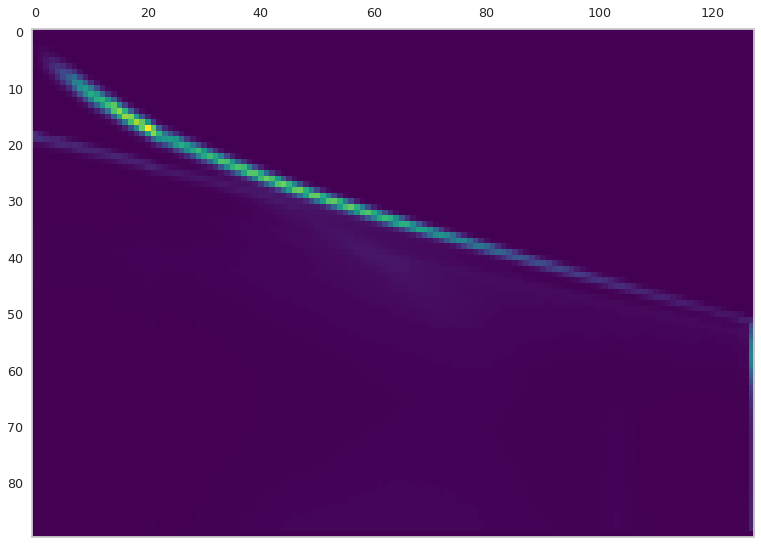

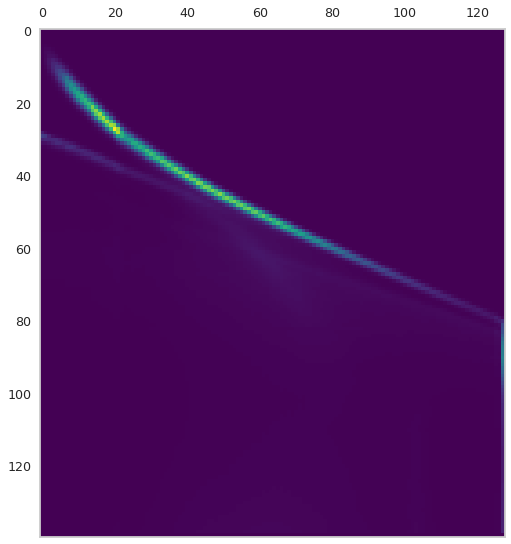

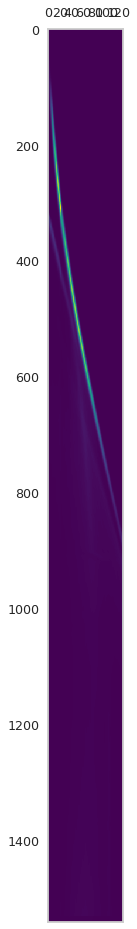

In [11]:
custom_edges = NaiTTEEdges.from_log_bins(n_bins=91)


gbm_n6_generator = DRMGenTTE(det_name= "n6",
                             trigdat = trigdat_file,
                             mat_type = 2, # direct response + atmospheric scattering
                             cspecfile = cspec_file,
                             # pass the custom edges
                             custom_input_edges=custom_edges
                            
                            )

gbm_n6_generator.set_location(ra=329,dec = -38.2)


plt.matshow(gbm_n6_generator.matrix.T)

custom_edges = NaiTTEEdges.from_log_bins(n_bins=141)


gbm_n6_generator = DRMGenTTE(det_name= "n6",
                             trigdat = trigdat_file,
                             mat_type = 2, # direct response + atmospheric scattering
                             cspecfile = cspec_file,
                             # pass the custom edges
                             custom_input_edges=custom_edges
                            
                            )

gbm_n6_generator.set_location(ra=329,dec = -38.2)


plt.matshow(gbm_n6_generator.matrix.T)



custom_edges = NaiTTEEdges.from_log_bins(n_bins=1541)


gbm_n6_generator = DRMGenTTE(det_name= "n6",
                             trigdat = trigdat_file,
                             mat_type = 2, # direct response + atmospheric scattering
                             cspecfile = cspec_file,
                             # pass the custom edges
                             custom_input_edges=custom_edges
                            
                            )

gbm_n6_generator.set_location(ra=329,dec = -38.2)


plt.matshow(gbm_n6_generator.matrix.T)

### a custom array

And we can even supply and entirely custom array of energies:

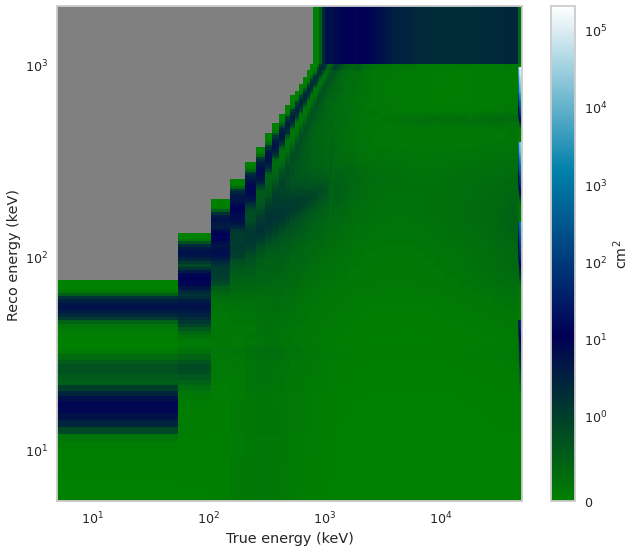

In [12]:
edges = np.linspace(5., 50000., 1001)


custom_edges = NaiTTEEdges.from_custom_array(edges)


gbm_n6_generator = DRMGenTTE(det_name= "n6",
                             trigdat = trigdat_file,
                             mat_type = 2, # direct response + atmospheric scattering
                             cspecfile = cspec_file,
                             # pass the custom edges
                             custom_input_edges=custom_edges
                            
                            )


response = gbm_n6_generator.to_3ML_response(ra=329,dec = -38.2)

fig = response.plot_matrix()